##### Copyright 2022 Sang Wook Kim.

In [1]:
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

In [5]:
import tensorflow as tf
print(tf.__version__)
# you may need the latest version of tensorflow

2.7.0


In [8]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time

from IPython import display

In [9]:
import cv2

In [13]:
%matplotlib inline

# Original image

(333, 500)


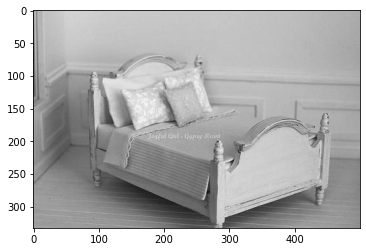

In [14]:
#check the image and see if it looks good
sample_grey = cv2.imread('./data/bed/00000001.jpg', cv2.IMREAD_GRAYSCALE)
print(sample_grey.shape)
plt.imshow(sample_grey, cmap=plt.get_cmap('gray'))

In [12]:
# check the gray image scale
print(np.amax(sample_grey))
sample_grey.astype('float32')

220


array([[ 94., 134., 169., ..., 150., 150., 151.],
       [ 95., 135., 170., ..., 147., 147., 147.],
       [ 95., 134., 170., ..., 146., 146., 146.],
       ...,
       [143., 143., 143., ..., 124., 124., 124.],
       [139., 141., 140., ..., 125., 124., 124.],
       [135., 139., 138., ..., 125., 125., 124.]], dtype=float32)

# traning images

(32, 32, 1)


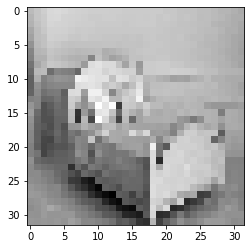

In [15]:
# resize it and see if it looks okay
img_shapes = (32,32)
IMG_SHAPE = (32,32,1)
sample_grey2 = cv2.resize(sample_grey, img_shapes)
sample_grey2 = (sample_grey2 - 127.5) / 127.5  # Normalize the images to [-1, 1]
# plt.imshow(sample_grey2, cmap=plt.get_cmap('gray'))
sample_grey3 = np.reshape(sample_grey2, IMG_SHAPE)
sample_grey3 = sample_grey3.astype('float32')
print(sample_grey3.shape)
plt.imshow(sample_grey3, cmap=plt.get_cmap('gray'))

In [16]:
# load image set
# Source : https://www.kaggle.com/akkithetechie/furniture-detector
# License : CC0: Public Domain
base_dir = './data/bed'
imgs = []
for file in os.listdir(base_dir):
    file_path = f"{base_dir}/{file}"
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # read in grayscale
    img = cv2.resize(img, img_shapes) # resize into 50,50
    img = (img - 127.5) / 127.5 # Normalize the image
    img = img.astype('float32')
    img = np.reshape(img, IMG_SHAPE)
    imgs.append(img)

In [17]:
imgs = np.asarray(imgs)
print(imgs.shape)

(1000, 32, 32, 1)


In [18]:
import random

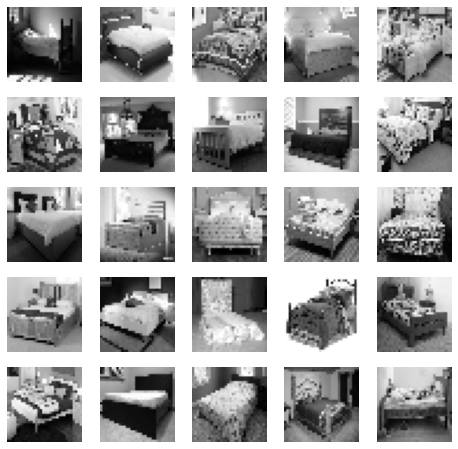

In [19]:
# Here are some images in the dataset
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(imgs[random.randint(0,1000)],cmap=plt.get_cmap('gray'))
        ax[i,j].axis('off')

In [20]:
# params = {'batch_size': 20, 
#           'noise_dims':100}
BATCH_SIZE = 10
noise_dim = 128
train_dataset = tf.data.Dataset.from_tensor_slices(imgs).batch(BATCH_SIZE)

In [21]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 1), types: tf.float32>

# Build models

#### Model inspired from Keras - WGAN-GP overriding

### Generator

In [22]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
#     x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 4096)              524288    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                       

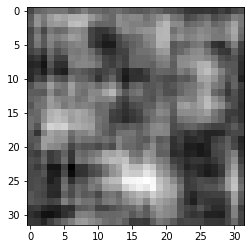

In [24]:
# untrained generator
generator = get_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

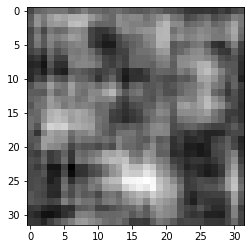

In [54]:
before = plt.figure('before')
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
before.savefig('./animated/before.jpg')

### Discriminator

In [25]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
#     x = layers.ZeroPadding2D((1, 1))(img_input)
#     x = layers.Cropping2D((4, 4))(img_input)
    x = conv_block(
        img_input,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)       

In [27]:
discriminator = get_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00049707]], shape=(1, 1), dtype=float32)


In [32]:
# Create the WGAN-GP model
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [33]:
!mkdir v2figs

In [34]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("./v2figs/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [35]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 100

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/100
100/100 [==============================] - 7s 39ms/step - d_loss: -4.3996 - g_loss: 13.8050
Epoch 2/100
100/100 [==============================] - 4s 38ms/step - d_loss: -2.9852 - g_loss: 6.6105
Epoch 3/100
100/100 [==============================] - 4s 38ms/step - d_loss: -2.6968 - g_loss: -3.3047
Epoch 4/100
100/100 [==============================] - 4s 38ms/step - d_loss: -3.0215 - g_loss: -6.6911
Epoch 5/100
100/100 [==============================] - 4s 38ms/step - d_loss: -2.7147 - g_loss: -7.1921
Epoch 6/100
100/100 [==============================] - 4s 38ms/step - d_loss: -3.1092 - g_loss: -6.7270
Epoch 7/100
100/100 [==============================] - 4s 38ms/step - d_loss: -2.2015 - g_loss: -9.2167
Epoch 8/100
100/100 [==============================] - 4s 38ms/step - d_loss: -3.1993 - g_loss: -7.6033
Epoch 9/100
100/100 [==============================] - 4s 38ms/step - d_loss: -1.7132 - g_loss: -13.5565
Epoch 10/100
100/100 [==============================] - 4s 38ms/

100/100 [==============================] - 4s 38ms/step - d_loss: 0.6231 - g_loss: -5.8264
Epoch 80/100
100/100 [==============================] - 4s 38ms/step - d_loss: 0.2912 - g_loss: 19.6664
Epoch 81/100
100/100 [==============================] - 4s 38ms/step - d_loss: -2.8895 - g_loss: 0.2861
Epoch 82/100
100/100 [==============================] - 4s 38ms/step - d_loss: -1.5349 - g_loss: -7.3907
Epoch 83/100
100/100 [==============================] - 4s 38ms/step - d_loss: -8.1674 - g_loss: -42.3101
Epoch 84/100
100/100 [==============================] - 4s 38ms/step - d_loss: -4.6171 - g_loss: -62.7687
Epoch 85/100
100/100 [==============================] - 4s 38ms/step - d_loss: 4.4112 - g_loss: 18.4908
Epoch 86/100
100/100 [==============================] - 4s 39ms/step - d_loss: 0.4982 - g_loss: 20.1048
Epoch 87/100
100/100 [==============================] - 4s 38ms/step - d_loss: 0.1874 - g_loss: 18.5056
Epoch 88/100
100/100 [==============================] - 4s 38ms/step - d

In [39]:
!pip install imageio

     |████████████████████████████████| 3.3 MB 5.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Save images

In [41]:
import imageio

In [42]:
!mkdir animated

In [43]:
# animate gif
anim_file = './animated/wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./v2figs/generated*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

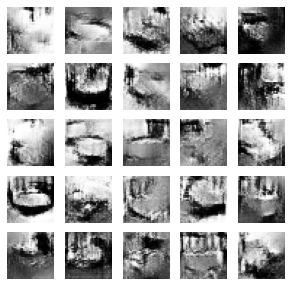

In [58]:
fig = plt.figure(figsize=(5, 5))
partition = 3

for i in range(25):
    get = i + partition*25
    plt.subplot(5, 5, i+1)
    result = cv2.imread(f'./v2figs/generated_img_2_{get}.png', cv2.IMREAD_GRAYSCALE)
    plt.imshow(result, cmap='gray')
    plt.axis('off')

fig.savefig(f'./animated/set{partition}.jpg')
plt.show()

### Animated gif

In [107]:
anim_file = './fig/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./fig/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)